In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
import copy
from scipy import misc

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

#import PT_files.save_load as sl
import loader
import time 
from collections import OrderedDict
import pdb

# Loading data/dataloaders

Below are our 2 datasets we'll be working with. Aptly named, `train_data` is the larger of the datasets due to this set being what the model is trained on. `test_data` is the smaller dataset used to see how well our model is doing. Do to the small dataset nature we only have a training and test sets. 

In [43]:
#Load the actual data that we're working on & print the shape of this data
train_data = loader.load('training_data610-2000.npy')
test_data = loader.load('test_data200-2000.npy')
print('Shape of train set=', train_data.shape)

Shape of train set= (2, 610, 1, 2000, 2000)


Converting training/test data to be RGB instead of grayscale because the model expects the data to be RGB

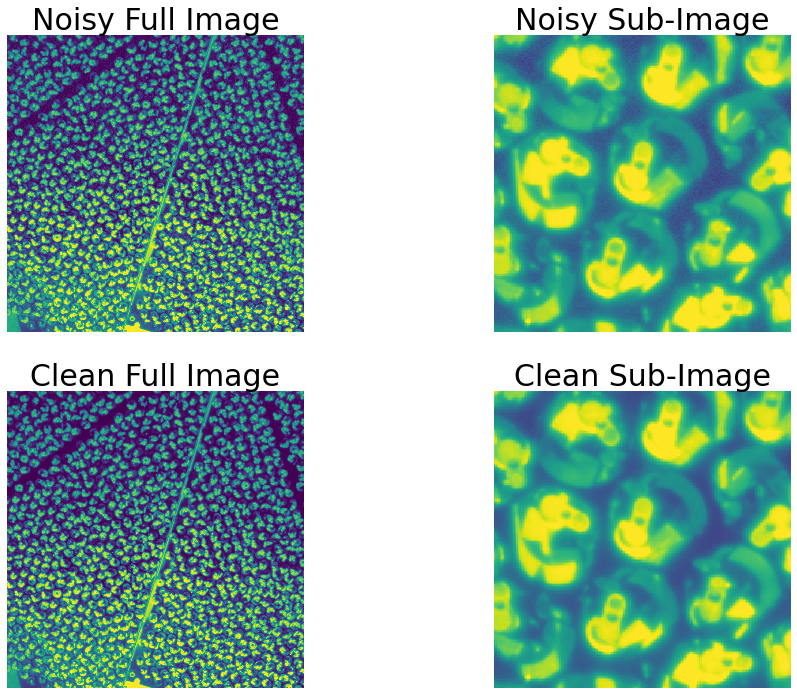

In [44]:
def display_data(data, sample_id, height, width):
    
    noise = data[0]
    label = data[1]
    
    fig, ax = plt.subplots(2, 2, figsize=(16,12))
    vmin, vmax = np.percentile(noise[sample_id], (1,99))


    ax[0, 0].imshow(noise[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0, 0].set_title('Noisy Full Image', fontsize=30)
    ax[0, 0].axis('off')
    ax[0, 1].imshow(noise[sample_id][0][height:height+200, width:width+200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0, 1].set_title('Noisy Sub-Image', fontsize=30)
    ax[0, 1].axis('off')
    ax[1, 0].imshow(label[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1, 0].set_title('Clean Full Image', fontsize=30)
    ax[1, 0].axis('off')
    ax[1, 1].imshow(label[sample_id][0][height:height+200, width:width+200], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1, 1].set_title('Clean Sub-Image', fontsize=30)
    ax[1, 1].axis('off')

display_data(data=train_data, sample_id=0, height=100, width=300)

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. [Source of this blurb and more info on PyTorch Dataset and Dataloaders found here.](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

This is our unique class to put our data, which in Numpy arrays, into the PyTorch primitive,`Dataset`. This will then be used in the other PyTorch primitive `Dataloader`.

In [45]:
class Img_Dataset(Dataset):
    def __init__(self, data_set, patch_size, width, height, seed=1234):
        """
        Parameters:
        -----------
        data: np.ndarray
            Array that contains image/label pairs ie. corrupted image/clean image.
            Shape = (P, N, C, H, W):
                P = corrupted/uncorrupted image pair 
                N = number of samples
                C = number of channels
                H = image height
                W = image width
        patch_size: int
            Size of randomly chosen image patch the model uses for training
        width: int
            Width of the chosen sample.
            NOTE: It's a parameter because you can input a larger image and choose
                  to look at only portions of said image for more training samples.
        height: int
            Height of the chosen sample.
        seed: int 
            Randomized seed used for the random slicing used to create the image patch.
        """
        self.data_set = data_set
        self.patch_size = patch_size
        self.width = width
        self.height = height
        self.seed = seed

    def __len__(self):
        return len(self.data_set[0])

    def __getitem__(self, idx):
        """
        Function that returns the PyTorch Dataloader compatible dataset.
        
        Parameters:
        -----------
        idx: var
            Variable used in PyTorch Dataloader to be able to sample from the dataset
            to create minibatches of the data for us automatically.
        """
        # Loading the dataset and then slicing the image/label pairs 
        # ie. corrupted/uncorrupted images. 
        # Note the use of the idx in the image/label variables. This allows the
        # PyTorch Dataloader to get all the important data info eg. (N, C, H, W)
        data = self.data_set
        image = data[0, idx]
        label = data[1, idx]
        
        # Setting the patch size and the randomized seed for the image patch
        patch_size = self.patch_size
        seed = self.seed
        rng = np.random.RandomState(seed)

        img_width = self.width
        img_height = self.height
        
        #randomly crop patch from training set
        x1 = rng.randint(img_width - patch_size)
        y1 = rng.randint(img_height - patch_size)
        S = (slice(y1, y1 + patch_size), slice(x1, x1 + patch_size))
        
        # create new arrays for training patchs
        image_patch = image[0][S]
        label_patch = label[0][S]
        

        image_patch = image_patch[np.newaxis, :, :]
        label_patch = label_patch[np.newaxis, :, :]
        
        image_patch = np.concatenate((image_patch,)*3, axis=0)
        label_patch = np.concatenate((label_patch,)*3, axis=0)

        
        # Turning our image/label to a PyTorch Tensor with dtype = float 
        # and then putting it onto the GPU for faster training/inference
        image = torch.from_numpy(image_patch).float().cuda(device)
        label = torch.from_numpy(label_patch).float().cuda(device)
            
        return image, label

In [46]:
train_ds = Img_Dataset(data_set=train_data,
                       patch_size=64,
                       height=2000,
                       width=2000)

test_ds = Img_Dataset(data_set=test_data,
                       patch_size=64,
                       height=2000,
                       width=2000)

In [47]:
train_dataloader = DataLoader(train_ds, batch_size=56, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=56, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([56, 3, 64, 64])
Labels batch shape: torch.Size([56, 3, 64, 64])


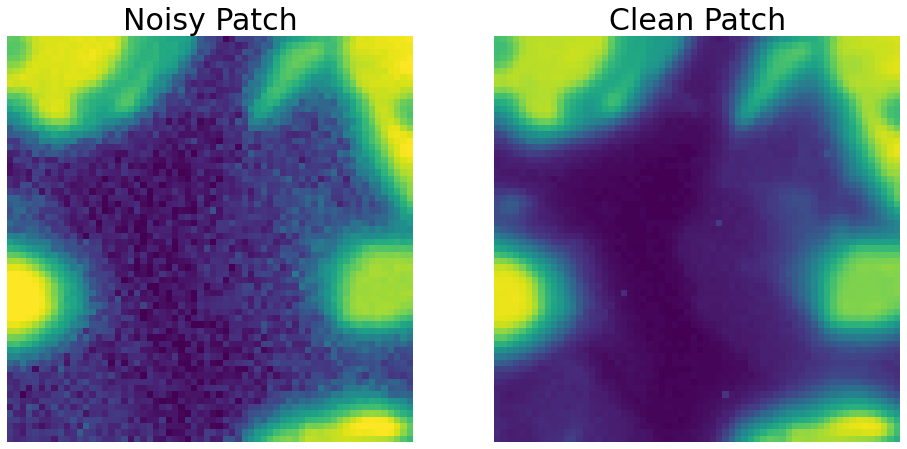

In [48]:
def display_training_pair(dataloader, sample_id):
    
    images, labels = next(iter(dataloader))    
    images = images.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    
    fig, ax = plt.subplots(1, 2, figsize=(16,12))
    vmin, vmax = np.percentile(images[sample_id][0], (1,99))


    ax[0].imshow(images[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].set_title('Noisy Patch', fontsize=30)
    ax[0].axis('off')
    ax[1].imshow(labels[sample_id][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].set_title('Clean Patch', fontsize=30)
    ax[1].axis('off')
    
display_training_pair(dataloader=train_dataloader, sample_id=0)

# Trying to get the papers code working for our FVC images

In [49]:
#Load the actual data that we're working on & print the shape of this data
train_data = loader.load('training_data610-2000.npy')
test_data = loader.load('test_data200-2000.npy')
print('Shape of train set=', train_data.shape)

Shape of train set= (2, 610, 1, 2000, 2000)


In [50]:
train_dataloader = DataLoader(train_ds, batch_size=56, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=56, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([56, 3, 64, 64])
Labels batch shape: torch.Size([56, 3, 64, 64])


In [51]:
PATH = pathlib.Path(os.getenv('PSCRATCH'))
DATA = PATH / 'DESI_dn' /'Model_params'
assert DATA.exists()

Model architecture

In [52]:
resnet = models.resnet18(pretrained=True)

In [53]:
resnet.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [54]:
layer3 = resnet.layer3
for idx, m in enumerate(layer3.named_modules()):
    print(idx, '->', m)

0 -> ('', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(

In [55]:
layer3 = resnet.layer3
for idx, m in layer3.named_modules():
    if 'conv1' in idx:
        print('Dilation =', m.dilation)
        print('Padding =', m.padding)
        print('Stride =', m.stride) 

Dilation = (1, 1)
Padding = (1, 1)
Stride = (2, 2)
Dilation = (1, 1)
Padding = (1, 1)
Stride = (1, 1)


In [108]:
def plot_model(input_data, output_data, samp_idx, out_chan):
    """
    Plotting function for NN model outputs compared to inputs.
    """
    
    fig, ax = plt.subplots(1, 2, figsize=(12,8))
    vmin, vmax = np.percentile(input_data[0][0].detach().cpu().numpy(), (1,99))
    vmin_out, vmax_out = np.percentile(output_data[0][0].detach().cpu().numpy(), (1,99))


    ax[0].imshow(input_data[samp_idx][0].detach().cpu().numpy(), vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].set_title('Input data', fontsize=30)
    ax[0].axis('on')
    ax[1].imshow(output[samp_idx][out_chan].detach().cpu().numpy(), origin='lower', interpolation='none')
    ax[1].set_title('Output data', fontsize=30)
    ax[1].axis('on')
    
    print('Input Data Shape =', input_data.shape)
    print('Output Data Shape =', output_data.shape)
    
    fig.tight_layout()
    

Checking what the shallow stream does. That is it keeps the image at full resolution, so that the output and the input are the same sizes. 

In [109]:
train_ds = Img_Dataset(data_set=train_data,
                       patch_size=1000,
                       height=2000,
                       width=2000)

test_ds = Img_Dataset(data_set=test_data,
                       patch_size=1000,
                       height=2000,
                       width=2000)

train_dataloader = DataLoader(train_ds, batch_size=56, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=3, shuffle=True)

In [110]:
# Shallow stream at full-resolution. This models output has the samee shape
# as the input. This is the simpler stream of the 2 stream architecture
shallow_net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2, bias=False), # Decrease size by 2 pixels in H/W
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2, bias=False), # Decrease size by 2 pixels in H/W
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
        )

shallow_net.to(device)

shallow_net.eval()

train_dataloader = DataLoader(train_ds, batch_size=56, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=3, shuffle=True)

noise, clean = next(iter(test_dataloader))
noise.shape
output = shallow_net(noise)

Input Data Shape = torch.Size([3, 3, 1000, 1000])
Output Data Shape = torch.Size([3, 32, 1000, 1000])


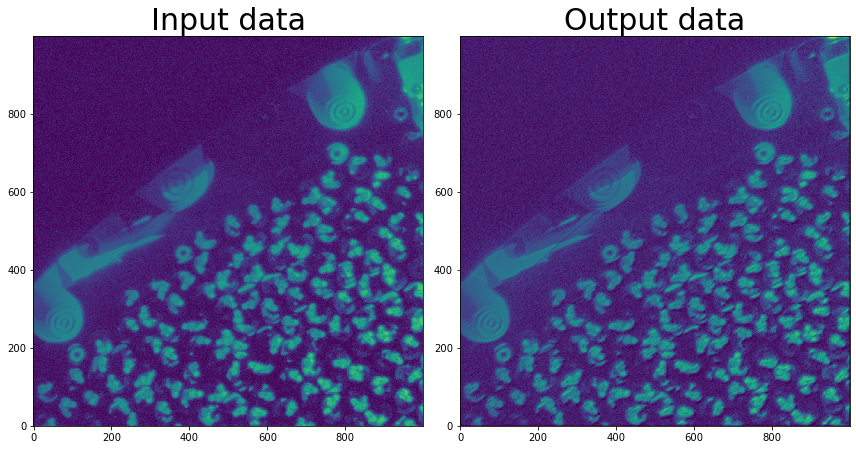

In [119]:
plot_model(input_data=noise, output_data=output, samp_idx=1, out_chan=30)

Checking the first layer of the deep stream

`layer0` downsamples the image by 4X as well as going from 3 channels -> 64 feature maps

In [127]:
layer00 = resnet.conv1
for idx, m in layer00.named_modules():
    

layer3 = resnet.layer3
for idx, m in layer3.named_modules():
    if 'conv1' in idx:
        print('Dilation =', m.dilation)
        print('Padding =', m.padding)
        print('Stride =', m.stride) 

<generator object Module.named_modules at 0x7f6cdee4fc10>

In [129]:
resnet.maxpool

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [123]:
print(resnet.conv1)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [ ]:
hin=1000
win=1000

hout = 

In [120]:
layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)


layer0.to(device)

layer0.eval()

test_dataloader = DataLoader(test_ds, batch_size=3, shuffle=True)

noise, clean = next(iter(test_dataloader))
noise.shape
output = layer0(noise)

Input Data Shape = torch.Size([3, 3, 1000, 1000])
Output Data Shape = torch.Size([3, 64, 250, 250])


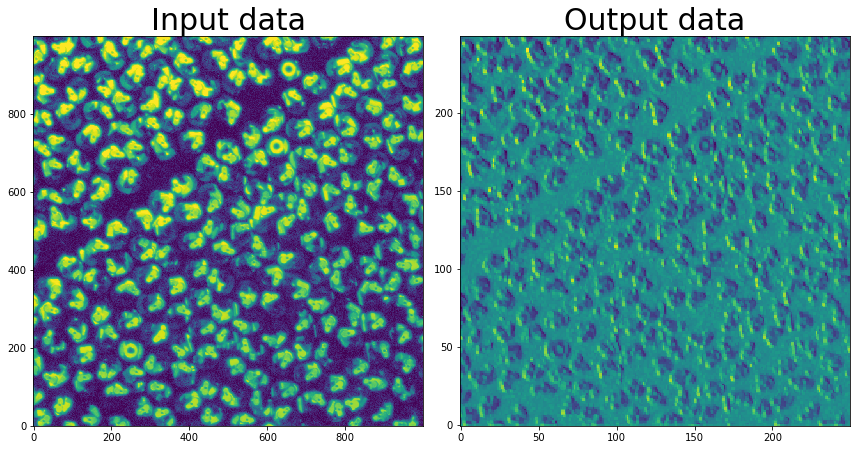

In [121]:
plot_model(input_data=noise, output_data=output, samp_idx=0, out_chan=20)

In [ ]:
class PixelEmbedModelResNet18(nn.Module):
    def __init__(self, emb_dimension=128, pretrained=True):
        super(PixelEmbedModelResNet18, self).__init__()
        self.emb_dimension = emb_dimension        
        
        resnet = models.resnet18(pretrained=pretrained)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        
                
        # tweak resnet backbone to output features 8x smaller than input image
        for n, m in self.layer3.named_modules():
            if 'conv1' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
        for n, m in self.layer4.named_modules():
            if 'conv1' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
        
        self.streamTwo_feats = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2, bias=False), # Decrease size by 2 pixels in H/W
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=2, dilation=2, bias=False), # Decrease size by 2 pixels in H/W
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
        )
        
                
        self.block5_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer4[-1].conv2.out_channels, emb_dimension, 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False), # emb_dimensions are out_channels
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension)
        )            
        self.block5_feats = nn.Sequential(
            nn.Conv2d(emb_dimension, emb_dimension, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension),
            
            nn.Conv2d(emb_dimension, emb_dimension, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension)
        )
        
                
        self.layer1_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer1[-1].conv2.out_channels, int(emb_dimension/2), 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        self.layer1_feats = nn.Sequential(
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2)),
            
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
                        
                
        self.layer2_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer2[-1].conv2.out_channels, int(emb_dimension/2), 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        self.layer2_feats = nn.Sequential(
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2)),
            
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
                

        self.layer3_dimRed = nn.Sequential(
            nn.Conv2d(resnet.layer3[-1].conv2.out_channels, int(emb_dimension/2), 
                      kernel_size=1, stride=1, padding=0, dilation=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        self.layer3_feats = nn.Sequential(
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2)),
            
            nn.Conv2d(int(emb_dimension/2), int(emb_dimension/2), kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(int(emb_dimension/2))
        )
        
        
        self.emb = nn.Sequential(
            nn.Conv2d(int(emb_dimension*2.5+32), emb_dimension, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension),
            
            nn.Conv2d(emb_dimension, emb_dimension, kernel_size=3, padding=1, bias=True),
            nn.ReLU(True),
            nn.BatchNorm2d(emb_dimension)
        )
        
        
    def forward(self, inputs):
        self.interp_x4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)  
        self.interp_x8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)  
        
        input_size = inputs.size()
        
        out = self.layer0(inputs)
        out_stream2 = self.streamTwo_feats(inputs)  # second shallow stream      
        
        out = self.layer1(out)        
        out_layer1 = self.layer1_dimRed(out)        
        out_layer1 = self.interp_x4(out_layer1)
        out_layer1 = self.layer2_feats(out_layer1)
        
        out = self.layer2(out)
        
        out_layer2 = self.layer2_dimRed(out)        
        out_layer2 = self.interp_x8(out_layer2)
        out_layer2 = self.layer2_feats(out_layer2)
        
        
        out = self.layer3(out)
        
        out_layer3 = self.layer3_dimRed(out)        
        out_layer3 = self.interp_x8(out_layer3)
        out_layer3 = self.layer3_feats(out_layer3)
        
        
        out = self.layer4(out)
        
        out = self.block5_dimRed(out)
        self.interp = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)        
        out = self.interp(out)        
        out = self.block5_feats(out)
            
     
        out = torch.cat([out_stream2, out_layer1, out_layer2, out_layer3, out], 1)
        out=self.emb(out)
                
        return out      
    